RAINSTORM - Created on Apr 18, 2024 - @author: Santiago D'hers

@author: Santiago D'hers

## Evaluate models
- This notebook will compare the performance of different trained models

#### Requirements:

- Models previously trained using RAINSTORM Create Models module
- A set of position files
- Labeled data for the position files (to train the model)

or

- Access to the example file **colabels.csv**, where we can find:
    - Position and labels for representative exploration events
    - It includes the labels of 5 viewers (so far)

---
#### 1. Load the necessary modules

In [1]:
import os
import pandas as pd
import rainstorm.evaluate_models as rst

---
#### 2. State your project path & thresholds
`base` : The path to the downloaded repository. If you are using a Windows path with backslashes, place an ‘r’ in front of the directory path to avoid an error (e.g. r'C:\Users\dhers\Desktop\RAINSTORM').

`objects` : Name the stationary objects that appear on your data.

`bodyparts` : Name the bodyparts you want to use for training (to simplify the model, it is better to leave out the tail).

`labelers` : Names of the people that labeled the data (they should be the same as the columns in the `colabels` file).

`past` & `future` : If you use a LSTM model, you can set the window size by saying how many frames into the past and how many into the future you want to see.

`broad` : Once you have your window size, we can broaden the window by skipping some frames as we stray further from the present.

`use_model` : The name of the model you want to use for evaluation.

In [2]:
# State your path:
base = r'C:\Users\dhers\Desktop\RAINSTORM'
models_folder = os.path.join(base, r'docs\models')
colabels = os.path.join(models_folder, 'colabels.csv')

objects = ['obj']
bodyparts = ['nose', 'L_ear', 'R_ear', 'head', 'neck', 'body']
labelers = ['Marian', 'Agus', 'Santi', 'Guille', 'Myself']

colabels_df = pd.read_csv(colabels)
position = colabels_df.filter(regex='_x|_y').filter(regex='^(?!.*tail)').copy() # Extract positions, excluding tail-related columns
manual_labels = pd.concat([colabels_df.filter(regex=name).copy() for name in labelers], axis=1) # Extract individual labelers' columns
geometric = colabels_df.filter(regex='Geometric').copy() # Extract geometric labels

past, future = 3, 3 # if you use a LSTM model, you can set the window size here
broad = 1.7 # using the same amount of frames, set how broad the window is (skipping frames)
broad_frames = rst.broaden(past, future, broad)
print(f'LSTM frame window: {broad_frames}')

use_model = 'example'

LSTM frame window: [-6, -3, -1, 0, 1, 3, 6]


---
#### 3. Calculate a good reference labeler
Since we want to compare the models and the labelers, we need to create a reference labeler.

This reference could be the mean of all the labelers, but then the labelers would have an unfair advantage.

To avoid this, we choose to simultaneously create a chimera labeler and a leave-one-out-mean:
- The chimera is created by randoml selecting a labeler on each row of the data.
- The leave-one-out-mean is created by averaging the remaining labelers.

This way, we can compare the chimera to the leave-one-out-mean knowing that they are independent.

In [ ]:
# Create the chimera and the leave-one-out mean
chimera, loo_mean = rst.create_chimera_and_loo_mean(manual_labels, seed=42) 
loo_mean = rst.smooth_columns(loo_mean, columns=['loo_mean'])

In [ ]:
full_mean = manual_labels.sum(axis=1)/manual_labels.shape[1]

10861.400000000573

---
#### 4. Load the models

In [4]:
# Load the saved models
from keras.models import load_model
model_simple = load_model(os.path.join(models_folder, f'm_simple/simple_{use_model}.keras'))
model_wide = load_model(os.path.join(models_folder, f'm_wide/wide_{use_model}_{len(broad_frames)}w.keras'))

from joblib import load
RF_model = load(os.path.join(models_folder, f'm_RF/RF_{use_model}.pkl'))

C:\Users\dhers\AppData\Roaming\Python\Python310\site-packages\keras\layers\core\lambda_layer.py:327: UserWarning: rainstorm.create_models is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(


In [5]:
X_all = position.copy()

all_simple = rst.use_model(X_all, model_simple, objects=['obj'])
all_wide = rst.use_model(X_all, model_wide, objects=['obj'], reshaping = True, past=past, future=future, broad=broad)
all_RF = rst.use_model(X_all, RF_model, objects=['obj'])

5220/5220 [==============================] - 15s 2ms/step


c:\Users\dhers\miniconda3\envs\storm\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [ ]:
all_labelers = {'simple': all_simple, 'wide': all_wide, 'RF': all_RF,
                'chimera': chimera, 'mean': loo_mean, 'full_mean': full_mean, 'geometric': geometric,}

for name in labelers:
    all_labelers[name] = colabels_df.filter(regex=name).copy()

# Verify the updated dictionary
print(all_labelers.keys())  # Check the keys to confirm the additions

dict_keys(['simple', 'wide', 'RF', 'chimera', 'mean', 'Marian', 'Agus', 'Santi', 'Guille', 'Myself'])


In [7]:
for name, pred in all_labelers.items():
    accuracy, precision, recall, f1, mse, mae, r2 = rst.evaluate(pred, loo_mean)
    print(f"Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 Score = {f1:.4f}, MSE = {mse:.4f}, MAE = {mae:.4f}, R-squared = {r2:.4f} -> {name}")

Accuracy = 0.9829, Precision = 0.9841, Recall = 0.9829, F1 Score = 0.9833, MSE = 0.0082, MAE = 0.0229, R-squared = 0.8457 -> simple
Accuracy = 0.9840, Precision = 0.9857, Recall = 0.9840, F1 Score = 0.9845, MSE = 0.0073, MAE = 0.0198, R-squared = 0.8622 -> wide
Accuracy = 0.9850, Precision = 0.9868, Recall = 0.9850, F1 Score = 0.9856, MSE = 0.0110, MAE = 0.0172, R-squared = 0.7915 -> RF
Accuracy = 0.9785, Precision = 0.9798, Recall = 0.9785, F1 Score = 0.9790, MSE = 0.0176, MAE = 0.0238, R-squared = 0.6670 -> chimera
Accuracy = 1.0000, Precision = 1.0000, Recall = 1.0000, F1 Score = 1.0000, MSE = 0.0000, MAE = 0.0000, R-squared = 1.0000 -> mean
Accuracy = 0.9799, Precision = 0.9846, Recall = 0.9799, F1 Score = 0.9812, MSE = 0.0124, MAE = 0.0186, R-squared = 0.7652 -> Marian
Accuracy = 0.9801, Precision = 0.9802, Recall = 0.9801, F1 Score = 0.9783, MSE = 0.0186, MAE = 0.0248, R-squared = 0.6488 -> Agus
Accuracy = 0.9679, Precision = 0.9786, Recall = 0.9679, F1 Score = 0.9710, MSE = 0.02

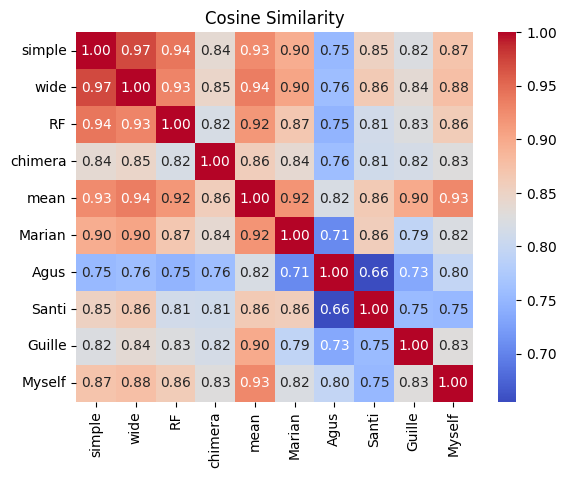

In [8]:
cosine_sim = rst.calculate_cosine_sim(all_labelers)

In [9]:
rst.plot_PCA(all_labelers)

NameError: name 'all_labelers' is not defined

<Figure size 640x480 with 0 Axes>

Now we can use the models in an example video

In [ ]:
# Prepare the dataset of a video we want to analyze and see
X_view = pd.read_csv(os.path.join(base, r'docs\examples\labeled_video\Example_position.csv')).filter(regex='^(?!.*tail)')

labels_A = pd.read_csv(os.path.join(base, r'docs\examples\labeled_video\Example_Marian.csv'))
labels_B = pd.read_csv(os.path.join(base, r'docs\examples\labeled_video\Example_Agus.csv'))
labels_C = pd.read_csv(os.path.join(base, r'docs\examples\labeled_video\Example_Santi.csv'))
labels_D = pd.read_csv(os.path.join(base, r'docs\examples\labeled_video\Example_Guille.csv'))
labels_E = pd.read_csv(os.path.join(base, r'docs\examples\labeled_video\Example_Myself.csv'))

dfs_example = [labels_A, labels_B, labels_C, labels_D, labels_E]

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\dhers\\Desktop\\RAINSTORM\\docs\\examples\\labeled_video\\Example_position.csv'

In [ ]:
autolabels_simple = rst.use_model(X_view, model_simple)
autolabels_wide = rst.use_model(X_view, model_wide, reshaping = True)
autolabels_RF = rst.use_model(X_view, RF_model)

469/469 [==============================] - 5s 12ms/step


c:\Users\dhers\anaconda3\envs\GPU\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [ ]:
import plotly.graph_objects as go
import numpy as np

plot_obj = "obj_1"

# Create a time axis (frame number divided by frame rate gives time in seconds)
time = np.arange(len(autolabels_simple[plot_obj])) / 25

# Create a figure
fig = go.Figure()

# Add traces for each label set
fig.add_trace(go.Scatter(x=time, y=[x * 1.025 for x in labels_A[plot_obj]], mode='markers', name='lblr_A', marker=dict(color='magenta')))
fig.add_trace(go.Scatter(x=time, y=[x * 1.05 for x in labels_B[plot_obj]], mode='markers', name='lblr_B', marker=dict(color='cyan')))
fig.add_trace(go.Scatter(x=time, y=[x * 1.075 for x in labels_C[plot_obj]], mode='markers', name='lblr_C', marker=dict(color='orange')))
fig.add_trace(go.Scatter(x=time, y=[x * 1.10 for x in labels_D[plot_obj]], mode='markers', name='lblr_D', marker=dict(color='purple')))
fig.add_trace(go.Scatter(x=time, y=[x * 1.125 for x in labels_E[plot_obj]], mode='markers', name='lblr_E', marker=dict(color='black')))

# fig.add_trace(go.Scatter(x=list(range(len(avrg_example["obj_1"]))), y=avrg_example["obj_1"], mode='lines', name='Average', line=dict(color='black')))

fig.add_trace(go.Scatter(x=time, y=autolabels_RF[plot_obj], mode='lines', name='RF', line=dict(color='gray', width=2)))
fig.add_trace(go.Scatter(x=time, y=autolabels_simple[plot_obj], mode='lines', name='Simple', line=dict(color='green', width=2)))
fig.add_trace(go.Scatter(x=time, y=autolabels_wide[plot_obj], mode='lines', name='Wide', line=dict(color='blue', width=2)))

# Add horizontal lines
fig.add_hline(y=0.5, line_dash="dash", line_color="black")

# Update layout
fig.update_layout(
title=dict(
        text=f'Performance of the models',
        x=0.5,
        y=0.95,
        xanchor='center',
        xref='paper'),
xaxis_title="Time (s)",
yaxis_title="Model output",
# legend=dict(yanchor="bottom", y=0.35, xanchor="left", x=0.2),  # Position the legend above the plot
# yaxis=dict(range=[None, 1.2]),
# xaxis=dict(range=[130, 144]),
margin=dict(t=60, b=20, l=20, r=20),
showlegend=True,
width=720,
height=480,
font=dict(size=18)
)

# Show the plot
fig.show()